# 자동화된 소프트웨어 개발팀 에이전트 만들기

## 필요 라이브러리 설치

In [25]:
%pip install langgraph

Note: you may need to restart the kernel to use updated packages.


## 필요 라이브러리 불러오기

In [26]:
import os
from typing import TypedDict, Annotated, Literal
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END, START

## GPT 모델 설정

In [27]:
from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

## 상태 정의
- 각 에이전트가 공유할 데이터 스키마

In [28]:
class State(TypedDict):
    requirement: str  # 사용자 요청 사항
    plan: str         # PM이 작성한 기획서
    code: str         # 개발자가 작성한 코드
    review: str       # 리뷰어의 피드백
    decision: str     # 리뷰 결과
    count: int        # 반복 횟수

## 노드 정의

In [29]:
# PM 노드 함수
def pm_node(state: State):
    print("\n[PM] 기획서 작성 중")
    requirement = state["requirement"]

    # PM 에이전트 시스템 프롬프트 작성
    prompt = f"사용자의 요청: '{requirement}'\n이 요청을 바탕으로 소프트웨어 개발을 위한 간단한 기획서를 작성해줘"
    response = llm.invoke([SystemMessage(content="너는 유능한 IT PM이야"), HumanMessage(content=prompt)])

    return {"plan": response.content, "count": 1}

In [30]:
# 개발자 노드 함수
def coder_node(state: State):
    print("\n[Coder] 코드 작성 혹은 수정 중")
    plan = state["plan"]
    review = state.get("review", "") # 이전 리뷰가 있다면 가져옴

    # 개발자 에이전트 시스템 프롬프트 작성
    if review:
        prompt = f"기획서: {plan}\n\n리뷰어 피드백: {review}\n\n피드백을 반영하여 코드를 수정해줘."
    else:
        prompt = f"기획서: {plan}\n\n이 기획서에 맞춰 파이썬 코드를 작성해줘."

    response = llm.invoke([SystemMessage(content="너는 숙련된 파이썬 개발자야. 코드만 깔끔하게 출력해줘."), HumanMessage(content=prompt)])

    return {"code": response.content}

- 리뷰어 에이전트를 통해 그래프의 순환 구조를 확인하기 위해 2번까지 거절

In [31]:
# 리뷰어 노드 함수
def reviewer_node(state: State):
    print("\n[Reviewer] 코드 검토 중")
    code = state["code"]
    count = state["count"]

    if count > 3: # 3번 이상 반복되면 강제 승인 (무한 루프 방지)
        return {"decision": "approve", "review": "반복 횟수 초과로 승인합니다."}

    # 리뷰어 에이전트 시스템 프롬프트 작성
    prompt = f"다음 코드를 검토해줘:\n{code}\n\n버그가 있거나 개선이 필요하면 'REJECT'로 시작하는 피드백을 주고, 완벽하면 'APPROVE'라고만 답해."
    response = llm.invoke([SystemMessage(content="너는 꼼꼼한 코드 리뷰어야."), HumanMessage(content=prompt)])

    review_content = response.content
    decision = "approve" if "APPROVE" in review_content.upper() else "reject"
    print(f"--> 판정: {decision}")

    return {"decision" : "reject", "review" : f"테스트상 {count}번 재검토 합니다.", "count" : count +1}
    # return {"decision": decision, "review": review_content, "count": count + 1}

## 그래프 정의
- StateGraph를 생성할 때 상태의 스키마로 State 전달
- 그래프가 처리할 데이터의 형태를 정의

In [32]:
graph = StateGraph(State)

## 노드 정의

In [33]:
graph.add_node("PM", pm_node)
graph.add_node("Coder", coder_node)
graph.add_node("Reviewer", reviewer_node)

## 엣지 정의

In [34]:
graph.add_edge(START, "PM")
graph.add_edge("PM", "Coder")
graph.add_edge("Coder", "Reviewer")

### 조건부 엣지 함수 정의
- `Literal` : `typing` 모듈 기능으로 변수나 반환 값이 특정 값들 중 하나만 가질 수 있음을 제한함

In [35]:
def check_review(state: State) -> Literal["Coder", "end"]:
    if state["decision"] == "approve":
        return "end"
    return "Coder"

### Reviewer의 결정에 따라 분기하는 조건부 엣지 추가

In [36]:
graph.add_conditional_edges(
    "Reviewer",
    check_review,
    {
        "Coder": "Coder",
        "end": END
    }
)

# 그래프 컴파일
app = graph.compile()

## 그래프 시각화

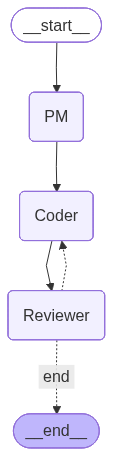

In [37]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

## 그래프 실행

In [39]:
inputs = {"requirement": "테트리스 게임을 파이썬으로 만들어줘"}
final_code = ""
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Finished: {key}\n {value}")
        if "code" in value:
                final_code = value["code"]

# 최종 결과 확인
print("\n[최종 완성 코드]")
print(final_code)


[PM] 기획서 작성 중
Finished: PM
 {'plan': '# 테트리스 게임 개발 기획서\n\n## 1. 프로젝트 개요\n- **프로젝트 이름**: Python Tetris\n- **목표**: 파이썬을 이용하여 기본적인 테트리스 게임을 개발하고, 사용자에게 재미있는 경험을 제공한다.\n- **타겟 사용자**: 모든 연령대의 게임 사용자, 특히 테트리스 팬 및 프로그래밍 학습자.\n\n## 2. 기능 요구사항\n### 2.1 기본 기능\n- **게임 시작/종료**: 사용자가 게임을 시작하고 종료할 수 있는 기능.\n- **테트로미노 생성**: 랜덤으로 테트로미노(블록)를 생성하고 화면에 표시.\n- **블록 회전**: 사용자가 블록을 회전할 수 있는 기능.\n- **블록 이동**: 블록을 좌우로 이동할 수 있는 기능.\n- **블록 하강**: 블록이 일정 시간마다 자동으로 아래로 하강.\n- **라인 제거**: 가득 찬 줄을 제거하고 점수 증가.\n- **게임 오버**: 블록이 쌓여서 화면 상단에 도달했을 때 게임 종료.\n\n### 2.2 추가 기능 (선택 사항)\n- **점수 시스템**: 줄을 제거할 때마다 점수를 계산하고 표시.\n- **레벨 시스템**: 점수가 일정 수준에 도달하면 레벨 업, 블록 하강 속도 증가.\n- **사운드 효과**: 게임 진행 중 효과음 및 배경음악 추가.\n- **UI 개선**: 사용자 인터페이스 디자인 및 개선.\n\n## 3. 기술 스택\n- **언어**: Python\n- **게임 라이브러리**: Pygame (게임 개발을 위한 파이썬 라이브러리)\n- **IDE**: Visual Studio Code, PyCharm 등\n\n## 4. 개발 일정\n| 단계            | 시작일       | 종료일       | 비고               |\n|----------------|--------------|--------------|--------------------|\n| 기획 및 설계   | YY